In [10]:
import sys
sys.path.append("../")

%load_ext autoreload
%autoreload 2

%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=3

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=3


In [11]:
import os
import cv2
import json
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms as T
from utils.helpers import generate_list_of_images, get_instance
from datasets import MassuchusettsDataset

import models

In [12]:
root_dir = "/scratch/saksham/data/road_segmentation_ideal/"

train_file = os.path.join(root_dir, "train.csv")
val_file = os.path.join(root_dir, "val.csv")
test_file = os.path.join(root_dir, "test.csv")

# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
exp_dir = "../saved/"
config_path  = "../configs/config-9.json"
config = json.load(open(config_path))

### Load weights

In [7]:
exp_name = os.path.join(exp_dir, config['name'])
weight_path = os.path.join(exp_name, "best_model.pth")
config = json.load(open(config_path))
model = get_instance(models, 'arch', config, config["trainer"]["num_classes"])

if os.path.exists(weight_path):
    best_model = torch.load(weight_path, map_location=DEVICE)
    print('Loaded model from this run.')
    
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in best_model["state_dict"].items():
    name = k[7:] # remove `module.`
    new_state_dict[name] = v
    
model.load_state_dict(new_state_dict)
model = model.cuda()
model.eval();

Loaded model from this run.


In [8]:
exp_name

'../saved/Exp6-Unet-OneCycleLR'

### Load data

In [51]:
train_dataset = MassuchusettsDataset(file_path = train_file, transforms = None)
val_dataset = MassuchusettsDataset(file_path = val_file, transforms = None)
test_dataset = MassuchusettsDataset(file_path = test_file, transforms = None)
test_dataset_viz = MassuchusettsDataset(file_path = test_file, transforms = None, preprocessing = False)

train_loader = DataLoader(train_dataset, shuffle=True, num_workers=4, batch_size = config["train_loader"]["batch_size"], pin_memory=True)
val_loader = DataLoader(val_dataset, shuffle=False, num_workers=4, batch_size= config["val_loader"]["batch_size"], pin_memory=True)
test_loader = DataLoader(test_dataset, shuffle=False, num_workers=4, batch_size= 1, pin_memory=True)

In [52]:
def one_hot_encode(label, label_values):
    """
    Convert a segmentation image label array to one-hot format
    by replacing each pixel value with a vector of length num_classes
    # Arguments
        label: The 2D array segmentation image label
        label_values
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of num_classes
    """
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)

    return semantic_map

### Visualise random image

In [53]:
def visualize(image, mask):
    fontsize = 18

    f, ax = plt.subplots(1, 2, figsize=(8, 8))

    ax[0].imshow(image)
    ax[1].imshow(mask)

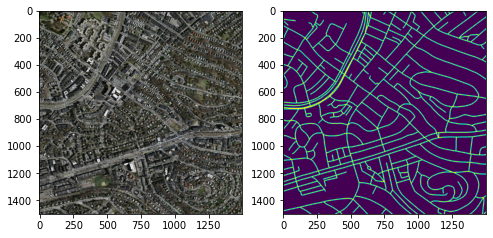

In [54]:
# get a random test image/mask index
random_idx = random.randint(0, len(test_dataset)-1)
image, mask = test_dataset_viz[random_idx]

visualize(
    image,
    mask
)

In [55]:
# define metrics

import segmentation_models_pytorch as smp

# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define metric
metrics = [
    smp.utils.metrics.IoU(threshold = None),
    smp.utils.metrics.Accuracy(threshold = None),
    smp.utils.metrics.Fscore(threshold = None),
    smp.utils.metrics.Precision(threshold = None),
    smp.utils.metrics.Recall(threshold = None)
]

# define loss
loss = smp.utils.losses.DiceLoss()

In [56]:
test_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

valid_logs = test_epoch.run(test_loader)

valid: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s, dice_loss - 1.128, iou_score - 0.5101, accuracy - 0.945, fscore - 0.6743, precision - 0.5746, recall - 0.8202] 


In [57]:
valid_logs

{'dice_loss': 1.127966413131127,
 'iou_score': 0.5101238970573132,
 'accuracy': 0.9450245316211994,
 'fscore': 0.6742804600642277,
 'precision': 0.574575797869609,
 'recall': 0.8201901316642761}

### Optimizing for threshold

In [58]:
import segmentation_models_pytorch as smp

# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

results = []

for th in np.linspace(0.0,1,21):
    # define metric
    metrics = [
        smp.utils.metrics.IoU(threshold = th),
        smp.utils.metrics.Fscore(threshold = th),
        smp.utils.metrics.Accuracy(threshold = th),
        smp.utils.metrics.Recall(threshold = th),
        smp.utils.metrics.Precision(threshold = th)
    ]

    # define loss
    loss = smp.utils.losses.DiceLoss()

    # run valudation epoch
    test_epoch = smp.utils.train.ValidEpoch(
        model,
        loss=loss,
        metrics=metrics, 
        device=DEVICE,
        verbose=True,
    )

    valid_logs = test_epoch.run(test_loader)
    valid_logs["threshold"] = th
    results.append(valid_logs)


valid: 100%|██████████| 13/13 [00:08<00:00,  1.45it/s, dice_loss - 1.128, iou_score - 8.455e-13, fscore - 8.455e-13, accuracy - 0.929, recall - 8.455e-13, precision - 1.0] 


In [59]:
v = {k: [dic[k] for dic in results] for k in results[0]}

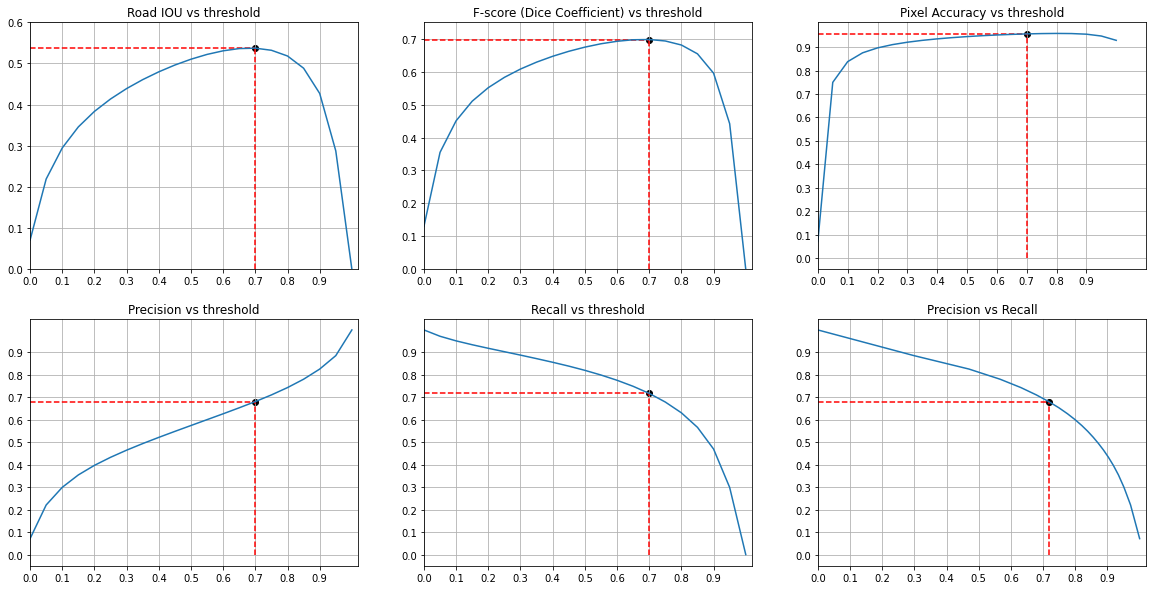

In [62]:
v["threshold"] = [round(v["threshold"][i], 2) for i in range(len(v["threshold"]))]  
x = 0.7
ind = v["threshold"].index(x)

fig = plt.figure(figsize=(20,10))
ax = []

ax.append(fig.add_subplot(2,3,1))
ax[0].set_xticks(np.arange(0, 1, 0.1))
ax[0].set_yticks(np.arange(0, 1, 0.1))
ax[0].set_title("Road IOU vs threshold")
plt.grid()
plt.plot(v["threshold"], v["iou_score"])

y = v["iou_score"][ind]
plt.vlines([x], 0, [y], linestyle="dashed", color = "red")
plt.hlines([y], 0, [x], linestyle="dashed", color = "red")
plt.scatter([x], [y], zorder=1, color = "black")
plt.xlim([0,1.02])
plt.ylim([0, 0.6])

ax.append(fig.add_subplot(2,3,2))
ax[1].set_xticks(np.arange(0, 1, 0.1))
ax[1].set_yticks(np.arange(0, 1, 0.1))
ax[1].set_title("F-score (Dice Coefficient) vs threshold")
plt.grid()
plt.plot(v["threshold"], v["fscore"])

y = v["fscore"][ind]
plt.vlines([x], 0, [y], linestyle="dashed", color = "red")
plt.hlines([y], 0, [x], linestyle="dashed", color = "red")
plt.scatter([x], [y], zorder=1, color = "black")
plt.xlim([0,1.02])
plt.ylim([0, 0.75])

ax.append(fig.add_subplot(2,3,3))
ax[2].set_xticks(np.arange(0, 1, 0.1))
ax[2].set_yticks(np.arange(0, 1, 0.1))
ax[2].set_title("Pixel Accuracy vs threshold")
plt.grid()
plt.plot(v["threshold"], v["accuracy"])

y = v["accuracy"][ind]
plt.vlines([x], 0, [y], linestyle="dashed", color = "red")
plt.hlines([y], 0, [x], linestyle="dashed", color = "red")
plt.scatter([x], [y], zorder=1, color = "black")
plt.xlim([0,1.10])

ax.append(fig.add_subplot(2,3,4))
ax[3].set_xticks(np.arange(0, 1, 0.1))
ax[3].set_yticks(np.arange(0, 1, 0.1))
ax[3].set_title("Precision vs threshold")
plt.grid()
plt.plot(v["threshold"], v["precision"])

y = v["precision"][ind]
plt.vlines([x], 0, [y], linestyle="dashed", color = "red")
plt.hlines([y], 0, [x], linestyle="dashed", color = "red")
plt.scatter([x], [y], zorder=1, color = "black")
plt.xlim([0,1.02])

ax.append(fig.add_subplot(2,3,5))
ax[4].set_xticks(np.arange(0, 1, 0.1))
ax[4].set_yticks(np.arange(0, 1, 0.1))
ax[4].set_title("Recall vs threshold")
plt.grid()
plt.plot(v["threshold"], v["recall"])

y = v["recall"][ind]
plt.vlines([x], 0, [y], linestyle="dashed", color = "red")
plt.hlines([y], 0, [x], linestyle="dashed", color = "red")
plt.scatter([x], [y], zorder=1, color = "black")
plt.xlim([0,1.02])

ax.append(fig.add_subplot(2,3,6))
ax[5].set_xticks(np.arange(0, 1, 0.1))
ax[5].set_yticks(np.arange(0, 1, 0.1))
ax[5].set_title("Precision vs Recall")
plt.grid()
plt.plot(v["recall"], v["precision"])

x_r = v["recall"][ind]
y = v["precision"][ind]
plt.vlines([x_r], 0, [y], linestyle="dashed", color = "red")
plt.hlines([y], 0, [x_r], linestyle="dashed", color = "red")
plt.scatter([x_r], [y], zorder=1, color = "black")
plt.xlim([0,1.02])

plt.show()

(0.0, 0.7)

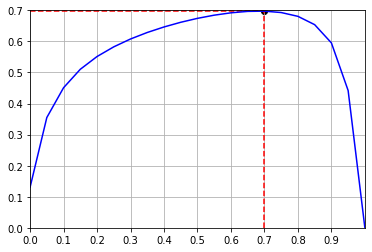

In [34]:
v = {k: [dic[k] for dic in results] for k in results[0]}
fig = plt.figure()
ax = fig.gca()
ax.set_xticks(np.arange(0, 1, 0.1))
ax.set_yticks(np.arange(0, 1., 0.1))
plt.grid()
plt.plot(v["threshold"], v["fscore"], color = "blue")

x = 0.7
v["threshold"] = [round(v["threshold"][i], 2) for i in range(len(v["threshold"]))]  
ind = v["threshold"].index(x)
y = v["fscore"][ind]

plt.vlines([x], 0, [y], linestyle="dashed", color = "red")
plt.hlines([y], 0, [x], linestyle="dashed", color = "red")
plt.scatter([x], [y], zorder=1, color = "black")
plt.xlim([0,1.0])
plt.ylim([0, 0.7])